<a href="https://colab.research.google.com/github/zuzka05/stat_learn/blob/main/video1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Build a Quant Trading Strategy

## Video 1: Build a ML Model in PyTorch

In [9]:
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [10]:
# y_hat = model(x)
#Prediction that takes inputs

# orders = strategy(y_hat)
#Take the predictions to create order, bias orders based on predictions to ensure inventory on the right side

# execute(orders)
#Send the orders to exchange

In [11]:
# regression model => BTCUSDT => future log return
#Real outputs number

#API and order book easy to collect on BTC

In [12]:
import os
print(os.getcwd())

/content


In [13]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data, times series
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  (to calculate weight and bias)
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities

In [109]:
!pip install "vegafusion[embed]>=1.5.0" "vl-convert-python>=1.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 89.2 MB/s eta 0:00:00


In [14]:
#Make sure the results are within a certain distance from each other
research.set_seed(42)

In [15]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [16]:
#Research parameters
# Trading pair symbol
sym = 'BTCUSDT'
# time horizon of time series (time interval)
#the interval for our time series
time_interval = '1h'
# Max number of auto-regressive lags
# Predict the future log return based on the past one
max_lags = 4
# Forecast horizon in steps
#Time interval is 1 hour
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [17]:
# old version that's in the video that should no longer used
# binance.download_trades(sym, hist_data_window)

# new version that downloads just the data showed in the video
start_date = datetime(2024, 10, 29, 0, 0)
end_date = datetime(2025, 10, 9, 0, 0)
binance.download_date_range(sym, start_date, end_date)

In [7]:
# this is the old version that's in the vide
# ts = research.load_ohlc_timeseries(sym, time_interval)
#stream it itervatively to build times series

# this version allows to get the same results in the video by fixing date range
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|██████████| 346/346 [02:05<00:00,  2.76day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8


In [8]:
#TS of the medium price, pass polar expressions
research.load_timeseries_range(sym, time_interval, start_date, end_date, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 346/346 [01:54<00:00,  3.02day/s]


datetime,price_median
datetime[μs],f64
2024-10-29 00:00:00,69848.5
2024-10-29 01:00:00,69969.0
2024-10-29 02:00:00,71180.1
2024-10-29 03:00:00,71170.5
2024-10-29 04:00:00,71029.3
…,…
2025-10-09 19:00:00,120839.8
2025-10-09 20:00:00,120942.8
2025-10-09 21:00:00,121300.7


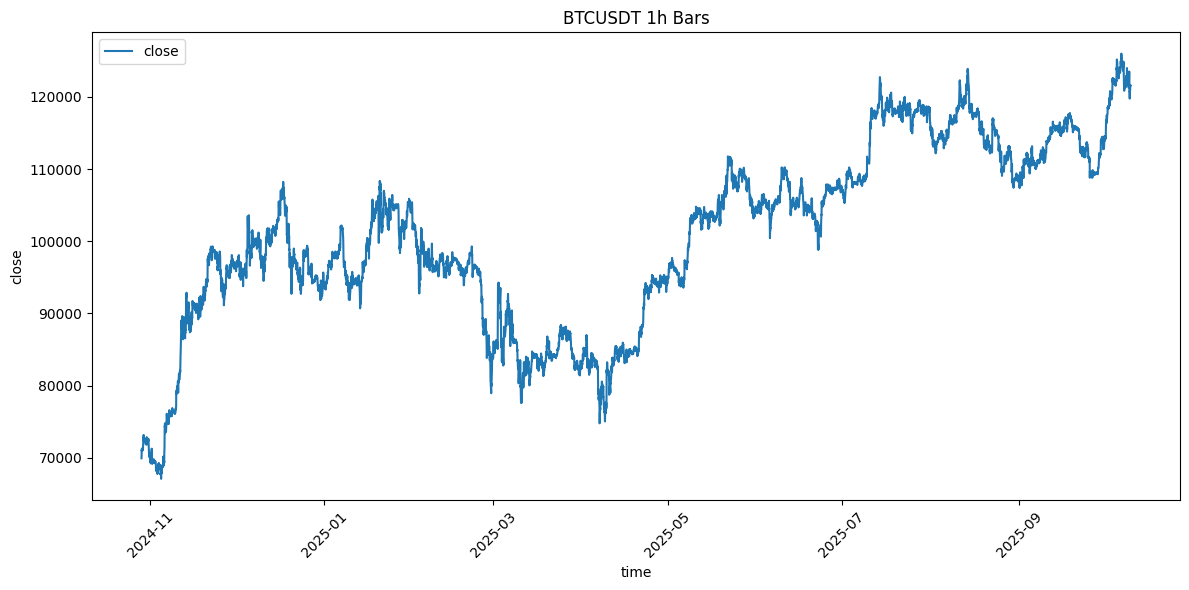

In [18]:
#Plot static ts, column and time interval
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [19]:
#Increase the allowance to display large datasets
#Dynamic chart
#alt.data_transformers.enable("vegafusion")
#research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

### Feature Engineering

In [20]:
#Features - What we are going to be predicting
#Predict log returns

In [21]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [22]:
#Create price movements series
#Take this price series and add columns to it
#Take the previous price which we get by shifting then divide by the previous price
#Take the price and divide it by the previous price, take the log of it - log return
#Returns are unitless, they're asymmetric

#Log returns are time-additive and symmetric and unitless
#How much money would I make if invest $100?
#Add delta - they can be added so you get the total net return and TR

In [23]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


### Create target and lagged features

In [24]:
#Create targets - what we're going to be predicting

In [25]:
#create target, add column
#by default it shifts by 1, but we add forecast_horizon by which it will be shifted
#the first row is empty, no previous points
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903
…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989


In [26]:
#Target as a variable to create lagged feature
#Shift - move the lag by 1

In [27]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [28]:
#We can add lags in a cleaner way

In [29]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [30]:
#it is important to drop all nulls

In [31]:
ts = ts.drop_nulls()

In [32]:
#We log_returns and we have a ND, with raw price is a multimodal distribution
#ML makes no assumptions about data (prices)

In [110]:
research.plot_distribution(ts, target, no_bins = 100)

alt.Chart(...)

In [111]:
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [35]:
#More intepretable and better generalization
#Use a super-constructor

In [36]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [37]:
#1 input, 1 output, bias is True. Weight and the bias

In [38]:
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [39]:
# y = w * x + b

### Split by time

In [40]:
#!!! Very important step
#Often we get data leakage here, don't leak any data that is not known

In [41]:
#AR1 - future return predicted on the current return
#We need some test data - most recent
#The oldest data for training
#Train-test split in scikit is to shuffle future and past
#Do it from scratch, not to use the library
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [42]:
len(ts)

8299

In [43]:
int(len(ts) * test_size)

2074

In [44]:
#to split the data by time, we split it by index
split_idx = int(len(ts) * (1-test_size))
split_idx

6224

In [45]:
#split ts to train and test data
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [46]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-07-15 08:00:00,116777.1,116871.0,116300.0,116766.5,-0.000091,-0.002343,-0.002341,-0.001333,0.002323
2025-07-15 09:00:00,116766.6,117229.9,116684.3,116764.9,-0.000014,-0.000091,-0.002343,-0.002341,-0.001333
2025-07-15 10:00:00,116765.0,117222.2,116728.1,117055.0,0.002481,-0.000014,-0.000091,-0.002343,-0.002341


In [47]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 13:00:00,117193.0,118499.8,117132.6,118067.7,0.007435,0.000706,0.000473,0.002481,-0.000014
2025-07-15 14:00:00,118067.8,118439.2,115678.1,115979.6,-0.017844,0.007435,0.000706,0.000473,0.002481
2025-07-15 15:00:00,115979.6,116752.9,115750.1,116393.0,0.003558,-0.017844,0.007435,0.000706,0.000473
2025-07-15 16:00:00,116393.1,117727.4,116360.9,117195.9,0.006874,0.003558,-0.017844,0.007435,0.000706
2025-07-15 17:00:00,117195.9,117577.1,117125.0,117415.6,0.001873,0.006874,0.003558,-0.017844,0.007435
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [48]:
#Convert the data to torch tensors

In [49]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
#Convert it to float64 tensor, no need to convert back to float32
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [50]:
X_train

tensor([[ 1.9030e-03],
        [-7.2779e-04],
        [ 3.0330e-03],
        ...,
        [-1.3703e-05],
        [ 2.4814e-03],
        [ 4.7317e-04]])

In [51]:
#2-dimensional tensor
#Rows and features
#1st dimension is row and 2nd dimension is feature
X_train.shape

torch.Size([6224, 1])

In [52]:
#Column vector - 1-dimensional tensor
#Convert it to 2-dimensional tensor
y_train

tensor([-0.0007,  0.0030, -0.0031,  ...,  0.0025,  0.0005,  0.0007])

In [53]:
y_train.shape

torch.Size([6224])

In [54]:
#it didn't change the data it just changed the shape of the tensor
#now, it's a row vector
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [ 0.0025],
        [ 0.0005],
        [ 0.0007]])

In [55]:
y_train.shape

torch.Size([6224, 1])

In [56]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0074],
        [-0.0178],
        [ 0.0036],
        ...,
        [ 0.0030],
        [ 0.0017],
        [-0.0003]])

In [57]:
#Now they're both 2-D tensors

In [58]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 1.9030e-03],
         [-7.2779e-04],
         [ 3.0330e-03],
         ...,
         [-1.3703e-05],
         [ 2.4814e-03],
         [ 4.7317e-04]]),
 tensor([[ 0.0007],
         [ 0.0074],
         [-0.0178],
         ...,
         [ 0.0012],
         [ 0.0030],
         [ 0.0017]]),
 tensor([[-0.0007],
         [ 0.0030],
         [-0.0031],
         ...,
         [ 0.0025],
         [ 0.0005],
         [ 0.0007]]),
 tensor([[ 0.0074],
         [-0.0178],
         [ 0.0036],
         ...,
         [ 0.0030],
         [ 0.0017],
         [-0.0003]]))

### Batch Gradient Descent

In [59]:
#Start learning, learn what the most optimal parameters are
#In practice mini batch gradient descent
#Here just use one batch, load all the data together

In [60]:
#hyperparameters - specific to the training
#lr - how much we adjust the weight by
#lr too large, weights increase by large amounts
#weights too small, change very slowly, then you can have more epochs
#that depends on the distribution of the data

#We want to experiment with the loss
#Outliers, abnormal price movements - it can have an impact on performance
#Optimizer -> Adam - it adapts the parameters of the optimization


In [61]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.0005

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass - passing all of the data
    y_hat = model(X_train)
    # ML - minimize the Loss, wuantified as MSE
    #Don't use any test data
    loss = criterion(y_hat, y_train)

    # backward pass
    # update the weights according to weight and the loss
    # zero out the gradients, otherwise it will cumulate the gradients
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    # see how our training is doing, if it is overfitting or stop prematurely - if not learning
    # we can exit prematurely if there's no improvement in the loss
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

#what is our weight and bias that is learned
print("\nLearned parameters")

#we're only interested in parameters if they're learnable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
# it turns off certain training layers, dropout
model.eval()
#tell torch no longer calculate gradients
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    #compare test and train loss - if big deviation most likely overfitting
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")



Training model...
Epoch [500/5000], Loss: 0.468828
Epoch [1000/5000], Loss: 0.234599
Epoch [1500/5000], Loss: 0.101732
Epoch [2000/5000], Loss: 0.036157
Epoch [2500/5000], Loss: 0.009766
Epoch [3000/5000], Loss: 0.001831
Epoch [3500/5000], Loss: 0.000232
Epoch [4000/5000], Loss: 0.000041
Epoch [4500/5000], Loss: 0.000029
Epoch [5000/5000], Loss: 0.000028

Learned parameters
linear.weight:
[[-0.0538914]]
linear.bias:
[0.00013368]

Test Loss: 0.000011, Train Loss: 0.000028


In [62]:
#The loss hasn't changed - terminate when no improvement
#Weight is negative - it is a MR model
#If the previous log return is positive then it flips the sign
#Test loss vs train loss - no huge deviation
#It doesn't tell us how profitable the strategy is, only that is minimize by a certain amount


### Test Trading Peformance

In [63]:
#with the test data, create some trade results
#create a new dataframe
#2D column vector, we want to squeeze it to 1 dimensional tensor
#y is the actual value, it is our y test
#with each trade did we win or not

#If we win the trade - look at y_hat - calculate the sign
#If this equal the sign of our actual value - then it is won
#The sign is our signal
#If we predict it's gonna go down '-1' gonna go up it is '1'
#calculate each trade's log return
#take the signal multiply by our y
#if we predict it's gonna go down, and it actually goes down, then it turns it into positive
#that's how we map it into train results
#build the equity curve by summing the log returns

#performance curve is a cummulative sum

In [64]:
#The Sign Multiplication Logic
#When you multiply your predicted sign by the actual return, here's what happens:
#Case 1: Correct Prediction (Profitable Trade)

#Scenario A: You predict down (-1) × Market goes down (negative return) = Positive P&L
#Example: -1 × (-0.02) = +0.02 ✓

#Scenario B: You predict up (+1) × Market goes up (positive return) = Positive P&L
#Example: +1 × (+0.02) = +0.02 ✓

In [65]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000096,0.007435,true,1.0,0.007435,0.007435
-0.000267,-0.017844,true,-1.0,0.017844,0.025279
0.001095,0.003558,true,1.0,0.003558,0.028837
-0.000058,0.006874,false,-1.0,-0.006874,0.021963
-0.000237,0.001873,false,-1.0,-0.001873,0.02009
…,…,…,…,…,…
0.000275,0.002465,true,1.0,0.002465,0.018513
8.6137e-7,0.001222,true,1.0,0.001222,0.019735
0.000068,0.002989,true,1.0,0.002989,0.022724


In [66]:
#Plot the equity curve
#It's hovering, we have some drawdowns, performance around 0
#Drawdown - peak of the equity curve - till the bottom

In [67]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [68]:
#With cum_max it tracks the peak when it goes through times series
#It shows us at each point what the drawdown is
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000096,0.007435,true,1.0,0.007435,0.007435,0.0
-0.000267,-0.017844,true,-1.0,0.017844,0.025279,0.0
0.001095,0.003558,true,1.0,0.003558,0.028837,0.0
-0.000058,0.006874,false,-1.0,-0.006874,0.021963,-0.006874
-0.000237,0.001873,false,-1.0,-0.001873,0.02009,-0.008747
…,…,…,…,…,…,…
0.000275,0.002465,true,1.0,0.002465,0.018513,-0.077479
8.6137e-7,0.001222,true,1.0,0.001222,0.019735,-0.076257
0.000068,0.002989,true,1.0,0.002989,0.022724,-0.073268


In [69]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.14714768528938293

In [70]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.1368335089903927)

In [71]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-136.83350899039272)

In [72]:

win_rate = trade_results['is_won'].mean()
win_rate

0.4959036144578313

In [73]:
#calculate the expected value

In [74]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

9.952400906535321e-06

In [75]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.020651236176490784

In [76]:

compound_return = np.exp(total_log_return)
compound_return

np.float64(1.020865948431715)

In [77]:
#Probably the negative value when TCs added
1000*compound_return

np.float64(1020.8659484317151)

In [78]:
#the lowest peak of our equity curve
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.05115584656596184

In [79]:
#the highest point on the equity curve
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.0959918349981308

In [80]:
#Measure of risk
std = trade_results['trade_log_return'].std()
std

0.0033079273998737335

In [113]:
#annualized_rate -> square root of the number of the trading periods
sharpe = ev / std * annualized_rate
sharpe

np.float64(0.2815943558905409)

In [114]:
#Dictionary of performance metrics
#Compare the models against each other in a df
#Then sort by metrics and pick which one is best

In [115]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2075,
 'win_rate': 0.4959036144578313,
 'avg_win': 0.0022900966530581563,
 'avg_loss': -0.002233134057472067,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.02237566001713276,
 'ev': 9.952400906535321e-06,
 'std': 0.0033079273998737335,
 'total_log_return': 0.020651236176490784,
 'compound_return': np.float64(1.020865948431715),
 'max_drawdown': -0.14714768528938293,
 'equity_trough': -0.05115584656596184,
 'equity_peak': 0.0959918349981308,
 'sharpe': np.float64(0.2815943558905437)}

In [116]:
#we looked at lag_1 now we look at lag_2, use linear model
#pass in the time series, the features the target, the model
#you can pass a different optimizer and a different loss function
#Sharp is better
#MR is negative on the weight
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [85]:
#Compare different lags between each other
#Benchmark each feature
# itertools - look at different combinations of 2-dimensional features space
# combos - experiment - looking at different features
#loss function is stateless - minimum absolute error L1

In [86]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",2075,0.520964,0.002262,-0.002261,0.029018,-0.019245,0.000095,0.003307,0.198121,1.21911,-0.186939,-0.023167,0.241709,2.702635,"""[-0.02519196]""","""7.274337258422747e-05"""
"""close_log_return_lag_3""","""close_log_return""",2075,0.501205,0.0023,-0.002223,0.029018,-0.022376,0.000044,0.003308,0.091227,1.095517,-0.254687,-0.202833,0.091558,1.244047,"""[-0.03210128]""","""8.997701661428437e-05"""
"""close_log_return_lag_4""","""close_log_return""",2075,0.499759,0.00228,-0.002243,0.029018,-0.022376,0.000018,0.003308,0.036744,1.037427,-0.142968,-0.08755,0.072348,0.501032,"""[-0.00134247]""","""7.22436816431582e-05"""
"""close_log_return_lag_1""","""close_log_return""",2075,0.495422,0.002295,-0.002228,0.029018,-0.022376,0.000013,0.003308,0.026936,1.027302,-0.203701,0.007435,0.215534,0.367288,"""[-0.07186378]""","""9.121478797169402e-05"""


In [87]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.020527,0.004165,-0.024077,0.006435
-0.020527,1.0,-0.020555,0.004284,-0.024028
0.004165,-0.020555,1.0,-0.020793,0.004187
-0.024077,0.004284,-0.020793,1.0,-0.020495
0.006435,-0.024028,0.004187,-0.020495,1.0


In [88]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

## Add Transaction Fees

In [89]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966
…,…,…,…,…,…,…,…,…,…
-0.000174,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049


In [90]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [91]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [92]:
model_trades['is_won'].mean()

0.52

In [93]:
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32,f32
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835,-9.202906,-8.104293,-9.202906,-8.104293
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609,-9.228185,-8.129572,-18.431091,-16.233864
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767,-9.213899,-8.115286,-27.644989,-24.34915
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493,-9.203466,-8.104854,-36.848457,-32.454002
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966,-9.212214,-8.113601,-46.060669,-40.567604
…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000174,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059,-9.212805,-8.114192,-19074.464844,-16799.232422
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438,-9.209119,-8.110506,-19083.673828,-16807.34375
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049,-9.207351,-8.108738,-19092.880859,-16815.453125


In [94]:
time_interval = '6h'
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts


Loading BTCUSDT: 100%|██████████| 346/346 [01:50<00:00,  3.13day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3
…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9


In [95]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9,null,null,null,null
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1,0.006026,null,null,null
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8,0.017493,0.006026,null,null
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5,0.000532,0.017493,0.006026,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3,-0.003073,0.000532,0.017493,0.006026
…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398


In [96]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005243,-0.005837,0.041011,-0.027085,0.000265,0.007678,0.091406,1.095714,-0.107804,-0.077902,0.100361,3.229774,"""[-0.06635377]""","""0.0005011901375837624"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00794158]""","""0.00047139523667283356"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00370021]""","""0.0004653916694223881"""


In [97]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.009991,-0.05972,-0.009533
-0.009991,1.0,-0.009586,-0.059841
-0.05972,-0.009586,1.0,-0.00873
-0.009533,-0.059841,-0.00873,1.0


In [98]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005243,-0.005837,0.041011,-0.027085,0.000265,0.007678,0.091406,1.095714,-0.107804,-0.077902,0.100361,3.229774,"""[-0.06619783]""","""0.0004998852964490652"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00758727]""","""0.0004667199100367725"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00386025]""","""0.00046681100502610207"""


In [99]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss(), test_size=0.3)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",415,0.546988,0.005407,-0.005376,0.041011,-0.027085,0.000522,0.007678,0.216666,1.241929,-0.103148,-0.000011,0.252987,6.364213,"""[-0.02600245]""","""0.00023226153280120343"""
"""close_log_return_lag_3""","""close_log_return""",415,0.53253,0.005503,-0.005267,0.041011,-0.027085,0.000469,0.007681,0.194468,1.214664,-0.13558,-0.010205,0.250161,5.709613,"""[-0.05903748]""","""0.0004448784457053989"""
"""close_log_return_lag_2""","""close_log_return""",415,0.549398,0.005155,-0.005682,0.028236,-0.041011,0.000272,0.007691,0.112835,1.119448,-0.16492,-0.032449,0.137133,3.308776,"""[-0.08242398]""","""0.00046750670298933983"""


In [100]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [101]:
research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

## Research 12 forecast horizon

In [102]:
time_interval = '12h'


In [103]:
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9,null,null,null,null,null
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1,0.006026,null,null,null,null
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8,0.017493,0.006026,null,null,null
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5,0.000532,0.017493,0.006026,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3,-0.003073,0.000532,0.017493,0.006026,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425,0.001761
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186,0.000425
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398,0.012186


In [104]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.547826,0.00536,-0.005691,0.041011,-0.027085,0.000363,0.007674,0.125268,1.133453,-0.096249,-0.035114,0.134223,4.428597,"""[-0.00581577 -0.06741702 -0.00502416]""","""0.0005049149040132761"""
"""close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005243,-0.005837,0.041011,-0.027085,0.000265,0.007678,0.091406,1.095714,-0.107804,-0.077902,0.100361,3.229774,"""[-0.06550111]""","""0.000496380147524178"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.547826,0.00525,-0.005824,0.041011,-0.027085,0.000243,0.007679,0.083798,1.08741,-0.105424,-0.062388,0.092753,2.960678,"""[-0.00751356 -0.06728571]""","""0.0004915986210107803"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.542029,0.005291,-0.005768,0.041011,-0.027085,0.000226,0.007679,0.078095,1.081226,-0.105911,-0.076008,0.08705,2.759004,"""[-0.06648928 -0.00435309]""","""0.0004902314976789057"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00710889]""","""0.0004693868395406753"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00364274]""","""0.00046999732148833573"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00266274 -0.00989023]""","""0.00046384549932554364"""


In [105]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.553623,0.005308,-0.005759,0.041011,-0.027085,0.000368,0.007674,0.127005,1.135423,-0.096249,-0.062197,0.13596,4.490131,"""[-0.00749049 -0.06727464]""","""0.00050969491712749"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.547826,0.005308,-0.005754,0.041011,-0.027085,0.000306,0.007676,0.105433,1.111191,-0.096249,-0.050819,0.114387,3.72613,"""[-0.0663776 -0.00423159]""","""0.0005068188766017556"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.547826,0.005281,-0.005786,0.041011,-0.027085,0.000277,0.007677,0.09556,1.100275,-0.096249,-0.035114,0.104515,3.376731,"""[-0.00644323 -0.06652328 -0.00492296]""","""0.0004986312706023455"""
"""close_log_return_lag_2""","""close_log_return""",345,0.542029,0.005203,-0.005872,0.041011,-0.027085,0.000131,0.007681,0.045259,1.046299,-0.107804,-0.085454,0.054214,1.598471,"""[-0.06582797]""","""0.0005011773318983614"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00789651]""","""0.0004744450270663947"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00401071]""","""0.000473118998343125"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00243203 -0.00978306]""","""0.00047918467316776514"""


In [106]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.568116,0.005507,-0.005514,0.041011,-0.027085,0.000747,0.007646,0.25777,1.294042,-0.089545,0.002746,0.266725,9.1462,"""[-0.02664651 -0.08628277 -0.0592085 ]""","""0.0005690752877853811"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.55942,0.005532,-0.005481,0.041011,-0.027085,0.00068,0.007652,0.234498,1.264274,-0.113477,0.002746,0.243452,8.31358,"""[-0.0665461 -0.06362822]""","""0.000586913840379566"""
"""close_log_return_lag_1""","""close_log_return""",345,0.556522,0.0054,-0.005648,0.041011,-0.027085,0.0005,0.007666,0.172627,1.188423,-0.103148,-0.014506,0.208948,6.109042,"""[-0.02603355]""","""0.0002293901634402573"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005429,-0.005604,0.041011,-0.027085,0.000344,0.007675,0.118591,1.12591,-0.11325,0.002746,0.144678,4.19206,"""[-0.05110669]""","""0.00046182062942534685"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005309,-0.005755,0.041011,-0.027085,0.000339,0.007675,0.116788,1.123881,-0.094305,-0.062197,0.125743,4.128185,"""[-0.02309694 -0.08146755]""","""0.0005162840825505555"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.556522,0.005224,-0.005868,0.041011,-0.027085,0.000305,0.007676,0.105197,1.110929,-0.135555,-0.030704,0.121145,3.717782,"""[-0.02356116 -0.05869077]""","""0.0005577397532761097"""
"""close_log_return_lag_2""","""close_log_return""",345,0.553623,0.005128,-0.005983,0.023101,-0.041011,0.000169,0.007681,0.058194,1.059921,-0.16492,-0.082428,0.082492,2.055534,"""[-0.08129701]""","""0.00046619458589702845"""


### Save Best Model (Sharpe 10 Model)

In [107]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [108]:
torch.save(model.state_dict(), 'model_weights.pth')